In [1]:
import numpy as np
import pandas as pd
import scipy.stats

from tqdm import tqdm
import os
import pickle as pkl
import time
import nltk
from textblob import TextBlob
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import pipeline
import matplotlib.pyplot as plt
tqdm.pandas()
nltk.download('vader_lexicon')
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import accuracy_score, roc_auc_score
from scipy import stats as sts
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sts
from sklearn.feature_selection import mutual_info_regression
import dash
from dash import dcc, html
import plotly.express as px
from dash.dependencies import Input, Output


/Users/ericsaikali/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/ada-2023-project-dataexplorers/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/ericsaikali/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/ada-2023-project-dataexplorers/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ericsaikali/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# DATA PREPROCESSING

In [2]:
DATA_FOLDER = 'data/MovieSummaries/'
ADDITIONAL_FOLDER = 'data/AdditionalData/'

In [3]:
# reading a txt file and convert it to a dataframe
def read_txt(path):
    df = pd.read_csv(path, sep='\t', header=None)
    return df

In [4]:
# importing the data
plots = pd.read_csv(DATA_FOLDER + 'plot_summaries.txt', header=None, sep="\t")
movies = pd.read_csv(DATA_FOLDER + 'movie.metadata.tsv', header=None, sep="\t")
characters = pd.read_csv(DATA_FOLDER + 'character.metadata.tsv', header=None, sep="\t")
names = pd.read_csv(DATA_FOLDER + 'name.clusters.txt', header=None, sep="\t")
tvtropes = pd.read_csv(DATA_FOLDER + 'tvtropes.clusters.txt', header=None, sep="\t")

In [5]:
# renaming columns the plots dataframe
plots.columns = ['wikipedia_movie_id', 'plot']

In [6]:
movies

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."


# RETRIEVE ENDINGS

In [7]:
# Sample synopsis
synopsis = plots.iloc[:, 1].loc[0]

In [8]:
def find_ending(plot, max_sentences=3):
    blob = TextBlob(plot)
    last_sentences = blob.sentences[-max_sentences:]  
    return " ".join([str(sentence) for sentence in last_sentences])

In [9]:
plots['endings'] = plots.iloc[:, 1].apply(lambda plot: find_ending(plot))

# SENTIMENT ANALYSIS

In [10]:
sia = SentimentIntensityAnalyzer()

In [11]:
def attribute_polar_sentiments(text):
    dico = sia.polarity_scores(text)
    return dico['neg'], dico['neu'], dico['pos'], dico['compound']

attribute_polar_sentiments("Then aymeric hugged eric.")

(0.0, 0.526, 0.474, 0.4019)

In [12]:
sentiments = plots['endings'].apply(lambda end: attribute_polar_sentiments(end))
sentiments_df = pd.DataFrame(sentiments.tolist(), columns=['ending_negativity', 'ending_neutrality', 'ending_positivity', 'ending_compound_sentiment'])
plots = plots.join(sentiments_df)

# ANALYSIS

## SENTIMENTS ONLY ANALYSIS

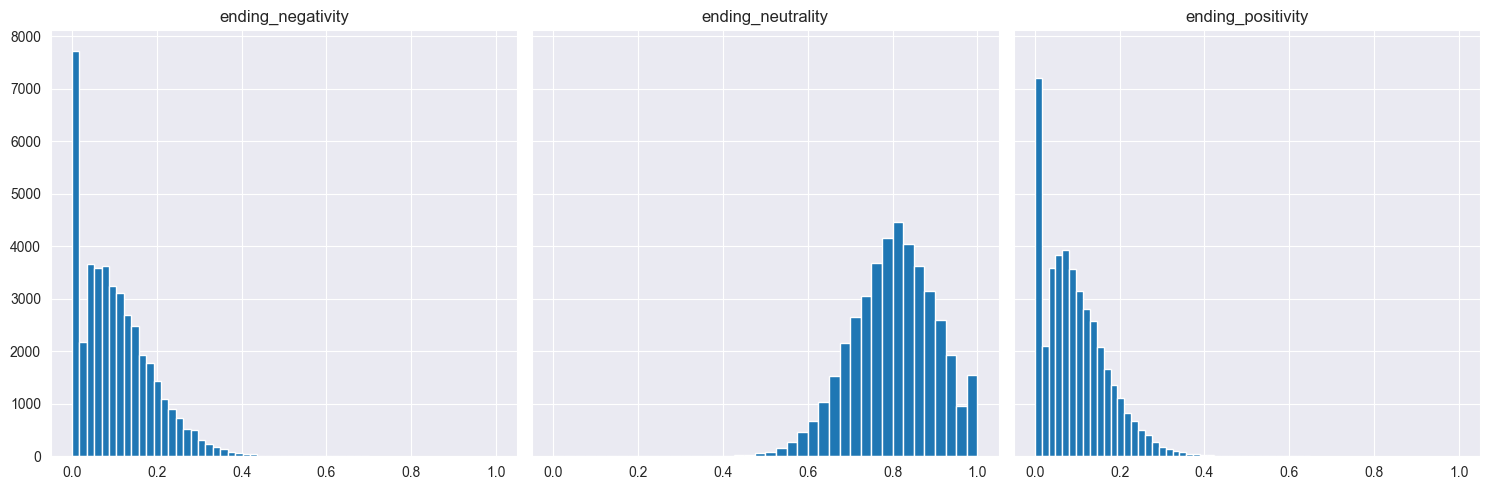

In [13]:
N_ROW = 1
N_COL = 3
fig, axs = plt.subplots(N_ROW, N_COL, figsize=(15, 5), sharey=True,sharex=True)

# Plotting histograms
for idx, col in enumerate(['ending_negativity', 'ending_neutrality', 'ending_positivity']):
    axs[idx].hist(plots[col], bins=40, label=col,)
    axs[idx].set_title(col)

plt.tight_layout()
plt.show()

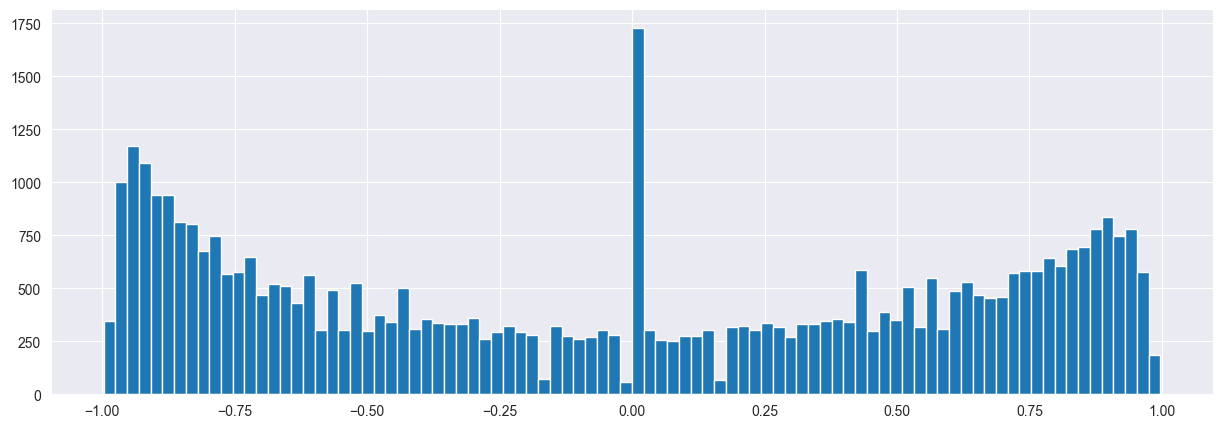

In [14]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.hist(plots['ending_compound_sentiment'],bins=90)
plt.show()


## MOVIE SCORE AND PROCESSING

In [15]:
with open(f'{ADDITIONAL_FOLDER}movie_scored_thresh_75.pkl',"rb") as f:
    movies = pkl.load(f)

In [16]:
movies_and_plots = pd.merge(movies, plots, how='left', on='wikipedia_movie_id')

## ANALYSIS

In [17]:
percentage = movies_and_plots.endings.isna().sum() / len(movies_and_plots) * 100
print(f"Movies without a given plot : {percentage:.2f}%")

Movies without a given plot : 20.87%


In [18]:
movies_with_plots = movies_and_plots[~movies_and_plots.endings.isna()]
movies_with_plots

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,budget,...,RC,movie_score,Good Movie,Generic Genre,plot,endings,ending_negativity,ending_neutrality,ending_positivity,ending_compound_sentiment
0,2466773,/m/07g1sm,The Godfather,1972-03-15,2.685000e+08,177.0,"{""/m/04h9h"": ""Latin Language"", ""/m/02bjrlw"": ""...","{""/m/09c7w0"": ""United States of America""}","[Crime Fiction, Gangster Film, Crime Drama, Fa...",6000000.0,...,0.987805,95.908194,1,"[Crime, Drama, Family, Period piece]","On the day of his only daughter's wedding, Vit...","Michael is confronted by Connie, who accuses h...",0.323,0.634,0.043,-0.9325
1,174251,/m/017jd9,The Lord of the Rings: The Return of the King,2003-12-17,1.119930e+09,250.0,"{""/m/05p2d"": ""Old English language"", ""/m/02h40...","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Fantasy Adventure, Adventure, Epic, Action/Ad...",94000000.0,...,0.963415,94.563911,1,"[Action, Adventure, Drama, Fantasy]","Gandalf, Aragorn, Legolas, Gimli, Théoden, Ga...","In the aftermath, Aragorn is crowned King, her...",0.000,0.860,0.140,0.9042
2,4276475,/m/0btpm6,The Dark Knight,2008-07-16,1.004558e+09,153.0,"{""/m/0653m"": ""Standard Mandarin"", ""/m/02h40lc""...","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Crime Fiction, Thriller, Superhero movie, Cri...",185000000.0,...,0.963415,93.949723,1,"[Action, Adventure, Crime, Drama, Thriller]","In Gotham City, the Joker and his accomplices...",Batman convinces Gordon to hold him publicly r...,0.134,0.715,0.151,-0.1779
4,52549,/m/0dtfn,Star Wars Episode IV: A New Hope,1977-05-25,7.753980e+08,122.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Science Fiction, Adventure, Fantasy, Coming o...",11000000.0,...,0.914634,93.846619,1,"[Action, Adventure, Family, Fantasy, Science F...",The film begins with an opening crawl explain...,Vader and a group of TIE fighters are about to...,0.286,0.564,0.150,-0.8674
5,73875,/m/0jsf6,The Godfather Part II,1974-12-12,1.930000e+08,200.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/09c7w0"": ""United States of America""}","[Crime Fiction, Gangster Film, Drama, Crime Dr...",13000000.0,...,0.963415,93.543061,1,"[Crime, Drama]",": In 1901 Corleone, Sicily, nine-year-old Vito...",Michael announces he has left college to enlis...,0.153,0.766,0.081,-0.4678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17759,22031391,/m/05pbc0k,Mega Shark Vs. Giant Octopus,2009-05-26,7.220000e+02,90.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Science Fiction, Action, Horror, Sci-Fi Horror]",NaN,...,0.170732,21.564511,0,"[Action, Horror, Science Fiction]","Off the coast of Alaska, oceanographer Emma Ma...","The two sink, dead, still locked from their ba...",0.161,0.787,0.053,-0.7717
17760,33323067,/m/06m9kx,Robotropolis,2011-09-02,1.180000e+02,80.0,{},{},"[Science Fiction, Action, Adventure]",NaN,...,0.243902,20.918441,0,"[Action, Adventure, Science Fiction]",A group of reporters are covering the unveilin...,A group of reporters are covering the unveilin...,0.079,0.921,0.000,-0.5023
17761,33528878,/m/0hgqtr_,7 Lives,2011-10-07,5.100000e+01,90.0,{},"{""/m/07ssc"": ""United Kingdom""}","[Thriller, Fantasy]",2500.0,...,0.280488,20.804988,0,"[Fantasy, Thriller]","Tom, a married man with kids, is struggling at...",On his way home one night he gets attacked by ...,0.097,0.856,0.047,-0.6124
17762,24873771,/m/03y8ltv,Thiruthani,2008,3.123000e+03,1440.0,"{""/m/07c9s"": ""Tamil Language""}","{""/m/03rk0"": ""India""}",[Action],NaN,...,0.073171,20.068884,0,[Action],The film opens with Bharath beating up men who...,"Shocked at this news, the doctor informs Bhara...",0.292,0.708,0.000,-0.9460


In [19]:
X = movies_with_plots[['ending_negativity', 'ending_positivity','ending_neutrality']].to_numpy()
y = movies_with_plots['movie_score'].to_numpy()


In [20]:
mutual_info = mutual_info_regression(X, y)
mutual_info

array([0.01361522, 0.00269025, 0.00999688])

Do end movie sentiment has a significant correlation with movie score ?

In [21]:
x = movies_with_plots['ending_compound_sentiment'].to_numpy()
mutual_info = mutual_info_regression(y.reshape(-1,1), x.reshape(-1,))
mutual_info

array([0])

This does not sound promissing, however, someone that wants to watch a horror movies might not want the movie to end with a love story...
To improve the naive analysis, let's compare using the genres.

In [22]:
exploded_df = movies_and_plots.explode('Generic Genre')
dummies = pd.get_dummies(exploded_df['Generic Genre'], dtype=int)
combined_df = pd.concat([exploded_df, dummies], axis=1)
genres_cols = list(dummies.columns.values)
genres_cols_with_id = genres_cols + ['wikipedia_movie_id']
one_hot_encoded_genres = combined_df[genres_cols_with_id].groupby('wikipedia_movie_id').sum()
one_hot_encoded_genres

,Action,Adventure,Animation,Comedy,Crime,Drama,Family,Fantasy,Horror,Musical,Period piece,Romance,Science Fiction,Sport,Thriller,War film
wikipedia_movie_id,,,,,,,,,,,,,,,,
3217,1,1,0,1,0,1,0,1,1,0,0,0,0,0,0,0
3333,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3746,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0
3837,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3947,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37174696,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
37210334,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
37241569,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
movies_and_plots = pd.merge(movies_and_plots, one_hot_encoded_genres, on='wikipedia_movie_id')
movies_with_plots = movies_and_plots[~movies_and_plots.endings.isna()]

In [24]:
movies_and_plots

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,budget,...,Family,Fantasy,Horror,Musical,Period piece,Romance,Science Fiction,Sport,Thriller,War film
0,2466773,/m/07g1sm,The Godfather,1972-03-15,2.685000e+08,177.0,"{""/m/04h9h"": ""Latin Language"", ""/m/02bjrlw"": ""...","{""/m/09c7w0"": ""United States of America""}","[Crime Fiction, Gangster Film, Crime Drama, Fa...",6000000.0,...,1,0,0,0,1,0,0,0,0,0
1,174251,/m/017jd9,The Lord of the Rings: The Return of the King,2003-12-17,1.119930e+09,250.0,"{""/m/05p2d"": ""Old English language"", ""/m/02h40...","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Fantasy Adventure, Adventure, Epic, Action/Ad...",94000000.0,...,0,1,0,0,0,0,0,0,0,0
2,4276475,/m/0btpm6,The Dark Knight,2008-07-16,1.004558e+09,153.0,"{""/m/0653m"": ""Standard Mandarin"", ""/m/02h40lc""...","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Crime Fiction, Thriller, Superhero movie, Cri...",185000000.0,...,0,0,0,0,0,0,0,0,1,0
3,4588970,/m/0cbckv,Anchorhead Story of Star Wars,1977-01-01 00:00:00,7.753980e+08,NaN,{},{},[],11000000.0,...,0,0,0,0,0,0,0,0,0,0
4,52549,/m/0dtfn,Star Wars Episode IV: A New Hope,1977-05-25,7.753980e+08,122.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Science Fiction, Adventure, Fantasy, Coming o...",11000000.0,...,1,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17759,22031391,/m/05pbc0k,Mega Shark Vs. Giant Octopus,2009-05-26,7.220000e+02,90.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Science Fiction, Action, Horror, Sci-Fi Horror]",NaN,...,0,0,1,0,0,0,1,0,0,0
17760,33323067,/m/06m9kx,Robotropolis,2011-09-02,1.180000e+02,80.0,{},{},"[Science Fiction, Action, Adventure]",NaN,...,0,0,0,0,0,0,1,0,0,0
17761,33528878,/m/0hgqtr_,7 Lives,2011-10-07,5.100000e+01,90.0,{},"{""/m/07ssc"": ""United Kingdom""}","[Thriller, Fantasy]",2500.0,...,0,1,0,0,0,0,0,0,1,0
17762,24873771,/m/03y8ltv,Thiruthani,2008,3.123000e+03,1440.0,"{""/m/07c9s"": ""Tamil Language""}","{""/m/03rk0"": ""India""}",[Action],NaN,...,0,0,0,0,0,0,0,0,0,0


In [25]:
sentiments_cols = ['ending_negativity', 'ending_positivity', 'ending_compound_sentiment']
genres_and_sentiments  = movies_with_plots[genres_cols+sentiments_cols + ['movie_score']]
genres_and_sentiments.loc[:,'sentiment_intensity'] = genres_and_sentiments['ending_compound_sentiment'].apply(np.abs)


/var/folders/vq/vpp5gf_96v7f5w4frq2kpfn00000gn/T/ipykernel_10500/2790649418.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genres_and_sentiments.loc[:,'sentiment_intensity'] = genres_and_sentiments['ending_compound_sentiment'].apply(np.abs)


Is a neutral ending of movies better or a more sentimental one ?

Film repartition is imbalanced and really pronounced on the edges
to address this issue, let's normalize the sentiment intensity:

In [135]:
genre_scores = {}
for i, genre in enumerate(genres_cols):
    movies_with_genre = genres_and_sentiments[genres_and_sentiments[genre] == 1]
    # Calculate correlation and mutual information
    correlation = sts.pearsonr(movies_with_genre['sentiment_intensity'], movies_with_genre['movie_score'])[0]
    information = mutual_info_regression(movies_with_genre[['sentiment_intensity']], movies_with_genre['movie_score'])[0]
    genre_scores[genre] = {'correlation': correlation, 'information': information}


In [134]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assuming 'data' is your dictionary


genres = list(genre_scores.keys())
correlations = [genre_scores[genre]['correlation'] for genre in genres]
informations = [genre_scores[genre]['information'] for genre in genres]

# Create subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Pearson correlations", "Mutual Information"))

# Add correlation bar plot
fig.add_trace(go.Bar(x=genres, y=correlations, name='Correlation'), row=1, col=1)

# Add information bar plot
fig.add_trace(go.Bar(x=genres, y=informations, name='Information'), row=1, col=2)

# Update layout
fig.update_layout(title_text="Genre Analysis between sentiment intensity and movie score", barmode='group')

# Show figure
fig.show()


In [127]:
app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Dropdown(
        id='genre-dropdown',
        options=[{'label': 'All', 'value': 'All'}] + [{'label': genre, 'value': genre} for genre in genres_cols],
        value='All',
        multi=True
    ),
    dcc.Graph(id='genre-plot'),
    
])
@app.callback(
    Output('genre-plot', 'figure'),
    [Input('genre-dropdown', 'value')]
)
def update_graph(selected_genres):
    needed_columns = ['movie_score','sentiment_intensity']
    if 'All' in selected_genres or not selected_genres:
        filtered_df = genres_and_sentiments[needed_columns]
        display(filtered_df)
    else:
        filtered_df = genres_and_sentiments[genres_and_sentiments[selected_genres].any(axis=1)][needed_columns]
    # Create the plot
    fig = px.density_contour(filtered_df, x='sentiment_intensity', y='movie_score')
    
    fig.update_traces(contours_coloring='fill', contours_showlabels=True)
    fig.update_layout(title='Density Contour of Movie Score vs Sentiment Intensity',
    xaxis_title='Sentiment Intensity',
    yaxis_title='Movie Score')
 


    return fig

if __name__ == '__main__':
    app.run_server(debug=True)
